## Naive Bayes Modeling and some EDA using: 
### - Transformer: TfidfVectorizer
### - Stemmed words

In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Other Sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# NLP imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download()  --> Download all, and then restart jupyter lab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

### Loading Data and Splitting Data

In [2]:
# Load the data
df = pd.read_csv('../../../data/clean_data/clean_posts.csv', index_col=0)
df.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length,clean_text_stem,clean_text_lem
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322,happen tolkien red book wonder somebodi could ...,happened tolkien red book wondering somebody c...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252,make peopl turn invis put one ring guess big q...,make people turn invisible put one ring guess ...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045,theori point told tale aragorn arwen must seri...,theory point told tale aragorn arwen must seri...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302,like purchas match set book everyth lotr silma...,like purchase matching set book everything lot...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731,faramir propos eowyn someth weird happen confe...,faramir proposes eowyn something weird happens...


In [3]:
# Checks baseline
df['subreddit'].value_counts(normalize=True)
# df['subreddit'].value_counts()

tolkienfans    0.516823
harrypotter    0.483177
Name: subreddit, dtype: float64

In [5]:
# Set up X and y
X = df['clean_text_stem']
y = df['subreddit']

In [6]:
# Splits the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state=42)

### Modeling Naive Bayes

In [7]:
# Baseline accuracy 
y_test.value_counts(normalize=True)

tolkienfans    0.516821
harrypotter    0.483179
Name: subreddit, dtype: float64

In [8]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [9]:
# Creates the pipe parameters 
pipe_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__min_df':[1, 2, 3],
    'tvec__max_df':[0.80, 0.90, 1],
    'tvec__ngram_range':[(1,1), (1,2), (1,3)]
#     'tvec__stop_words': [['would', 'like', 'know', 'think', 'could', 'first', 'http', 'get'],
#                         None]
}

In [10]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1,
                n_jobs=4)

In [11]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  8.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'tvec__max_df': [0.8, 0.9, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

#### Evaluation/results

In [12]:
# Outputs the training and test scores on first iteration of model
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9756063367447076, 0.9703532380151387)

In [13]:
# Prints out the best grid parameters
gs.best_params_

{'tvec__max_df': 0.8,
 'tvec__max_features': 5000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [14]:
# Assings the training accuracy score and the testing accuracy score to variable names
train1, test1 = gs.score(X_train, y_train), gs.score(X_test, y_test)
train1, test1

(0.9756063367447076, 0.9703532380151387)

In [15]:
# Calculates the y predictions and the AUC score
y_preds = gs.predict(X_test)
auc = roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])

In [16]:
# Creates the model metrics row dataframe to be added to the final model metrics table in presentation
results = pd.DataFrame({'Model': ['Multinomial NB'], 
                        'Transformer': ['TFIDF'],
                        'Stemmed/Lemmed': ['Stemmed'],
                        'Train_acc': [train1],
                        'Test_acc': [test1], 
                        'AUC': [auc]})
results.to_csv('../../../data/result_scores/nb_tfidf_stem.csv')

In [17]:
results

,Model,Transformer,Stemmed/Lemmed,Train_acc,Test_acc,AUC
0,Multinomial NB,TFIDF,Stemmed,0.975606,0.970353,0.997294


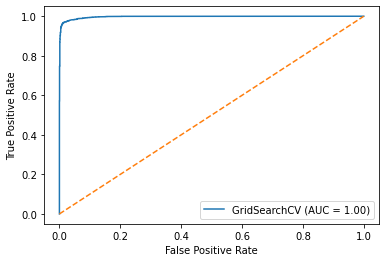

In [18]:
# Visualizes the ROC curve and the AUC score
plot_roc_curve(gs, X_test, y_test)
plt.plot([0,1],[0,1], label='baseline', linestyle='--');

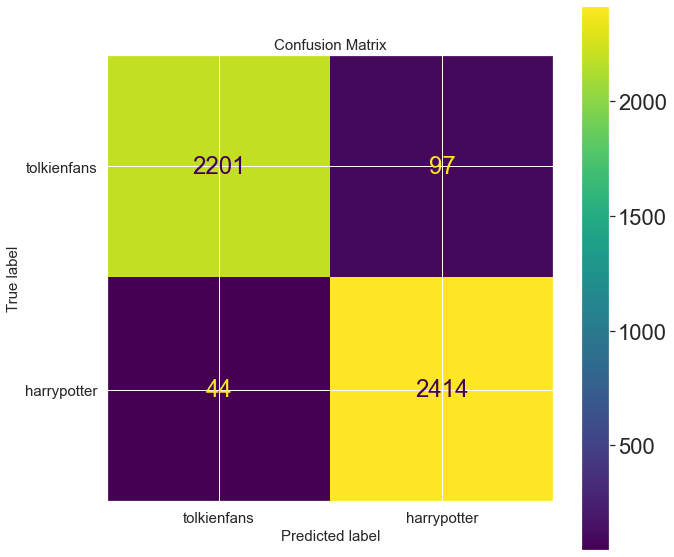

In [19]:
# Creates the confusion matrix and saves it as an image
sns.set(font_scale=2.0)
cm = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(10, 10))
plot = ConfusionMatrixDisplay(cm).plot(ax=ax)
plot
plt.title('Confusion Matrix')
ax.set_title('Confusion Matrix', fontdict={'size':'15'})
ax.set_xticklabels(df['subreddit'].unique(), size=15);
ax.set_yticklabels(df['subreddit'].unique(), size=15);
ax.set_xlabel('Predicted label', fontdict={'size':'15'})
ax.set_ylabel('True label', fontdict={'size':'15'})

plt.savefig('../../../presentation/imgs/cm_nb_tfidf_stem.jpg')

In [20]:
# Creates the coefs dictionary dataframe and then prints out the 10 smallest coefficients
coefs = gs.best_estimator_.named_steps['nb'].coef_
coefs = coefs.ravel()

names = gs.best_estimator_.named_steps['tvec'].get_feature_names()

coef_dict = pd.DataFrame({'coefs': coefs,
                      'features': pd.Series(names)})
coef_dict.nsmallest(10, columns=['coefs'])

,coefs,features
29,-10.670795,1st place
59,-10.670795,3rd place
76,-10.670795,9a
77,-10.670795,9d
78,-10.670795,9d 9a
96,-10.670795,accio
110,-10.670795,action tv
160,-10.670795,alan rickman
162,-10.670795,albu
163,-10.670795,albu dumbledor


In [21]:
# Prints out the 10 largest coefficients
coef_dict.nlargest(10, columns=['coefs'])

,coefs,features
4424,-4.954863,tolkien
3669,-5.216157,ring
3484,-5.297493,read
4876,-5.405482,would
554,-5.553512,book
3768,-5.567336,sauron
2088,-5.592730,hobbit
2512,-5.650292,like
1282,-5.660656,earth
2786,-5.692676,middl
